# generating videos of motion
Tim Tyree<br>
12.6.2020

In [1]:
%matplotlib inline
from lib.my_initialization import *
from lib.controller.integrate_forward_dormand_prince_asynchronous import *
from lib.controller.integrate_forward_implicit_asynchronous import *
%autocall 1
%load_ext autoreload
%autoreload 2


Automatic calling is: Smart


# import mesh

In [2]:
#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = .0#1.#1.;
#define adaptive time stepping absolute tolerances
salience = 2#128#32
learning_rate = np.log(salience) #np.log(16) #np.log(2)
lasso_fraction = 0.5#0.5
v_scale = 2.
mass_density=1.
stepsize_init = 0.0001#0.00001  #0.0001
atol_x = 1e-08#0.0001#0.001#1e-7; 
atol_v = 1e-08#0.0001#0.001#1e-7; 
btol_x = 1e-09#0.00001#0.001#1e-10; 
btol_v = 1e-09#0.00001#0.001#1e-10; 
input_file_name = f'../data/spherical_meshes/spherical_mesh_400.stl'#path to mesh
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'#path to mesh
data_folder =  os.path.join(nb_dir,'../data/mov_csv')#where to save results


data_fn = f"newmark_asynch_fixed_lr_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
TEXTfoo = lambda N_vertices,N_elements: f"""
TEXT=$'an inward squish
        Asynchronous Variational Integrator 
        Explicit Newmark Method
        
        Undamped Neohookean Model
        mu {mu}  lambda {lam} gamma {gamma}
        
        Spherical Mesh
        Num. Vertices {N_vertices}
        Num. Elements {N_elements}
'"""

# data_fn = f"avi_esynchronous_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"dormand_prince_synch_fixed_lr_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
save_folder_vid = '../vid/tmp'
folder_vid = '../vid'
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')
os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
N_elements = element_array_index.shape[0]
N_vertices = node_array_position.shape[0]
TEXT = TEXTfoo(N_vertices,N_elements)
print(list(dict_values_system.keys()))

#header to start of video
# TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
# TEXT = f"""
# TEXT=$'an inward squish
#         Synchronous Variational Integrator 
#         Explicit Newmark Method
        
#         Undamped Neohookean Model
#         mu {mu}  lambda {lam} gamma {gamma}
        
#         Spherical Mesh
#         Num. Vertices {N_vertices}
#         Num. Elements {N_elements}
# '"""

#write header to file
# print(TEXT)
# Dormand–Prince Method
# Explicit Newmark Method
# Implicit Midpoint Rule

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


# Explicit/Implicit Synchronous/Asynchronous Variational Integrator

- Mesh = solid sphere discretized by tetrahedra 
- Forces = neohookean hyperelastic material with rayleigh damping
- Initialization = inward initial velocity by an amount proportional to the x coordinate.

In [3]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [3.05175781e-09 6.10351563e-09 1.22070313e-08 2.44140625e-08
 4.88281250e-08 9.76562500e-08 1.95312500e-07 3.90625000e-07
 7.81250000e-07 1.56250000e-06 3.12500000e-06 6.25000000e-06
 1.25000000e-05 2.50000000e-05 5.00000000e-05 1.00000000e-04
 2.00000000e-04 4.00000000e-04 8.00000000e-04 1.60000000e-03
 3.20000000e-03 6.40000000e-03 1.28000000e-02 2.56000000e-02
 5.12000000e-02 1.02400000e-01 2.04800000e-01 4.09600000e-01
 8.19200000e-01 1.63840000e+00]


In [4]:
#choose your fighter
# integrate_system_explicit_synchronous = get_integrate_system_explicit_synchronous(mu,lam,gamma)
integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)
# integrate_system_implicit_synchronous = get_integrate_system_implicit_synchronous(mu,lam,gamma,num_iter=30)
# integrate_system_implicit_asynchronous = get_integrate_system_implicit_asynchronous(mu,lam,gamma)
# integrate_system_dormand_prince_synchronous = get_integrate_system_dormand_prince_synchronous(mu,lam,gamma)
# integrate_system_dormand_prince_asynchronous = get_integrate_system_dormand_prince_asynchronous(mu,lam,gamma,atol_x, atol_v, btol_x, btol_v,learning_rate, lasso_fraction)


#(optional) #view the mesh
# plot_mesh(vertices, input_file_name=input_file_name, darkmode=True)

In [5]:
# def get_integrate_system(mode):
#     if mode==0:
#         return integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
#     #     integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
#     #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
#     #     integrate_system_implicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,      element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
# #     integrate_system_dormand_prince_synchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities, node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
# #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities, node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)


In [6]:
#prepare for video
frameno = 1
time_between_observations = 0.01
time_of_next_observation = tme + time_between_observations
os.chdir(nb_dir)
os.chdir(folder_vid)
with open("mov/text.txt", "w") as file:
    file.write(TEXT)
    file.close()

#empty temp folder
os.chdir(nb_dir)
os.chdir(folder_vid)
folnm = os.path.basename(save_folder_vid)
shutil.rmtree(folnm)
os.mkdir(folnm)

In [7]:
#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)
time_end_recording = 10#.2
while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
    #     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,      element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)
#     integrate_system_dormand_prince_synchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities, node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
#     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities, node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
    try:
        img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
    except:
        pass
    save_fn_img = f'img{frameno:09}.png'
    frameno += 1
    Img = Image.fromarray(img)
    Img.save(save_fn_img)
    del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
beep(3)

/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_explicit_asynchronous.py:45: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  next_stepsize, retval, madval = step_forward_and_learn_simple(K_index, t_given, node_array_time, element_array_time, vertices, velocities, element_array_index,
/Users/timothytyree/Documents/GitHub/avi/nb/lib/measure/mesh_measures.py:35: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  element_array_energy = comp_element_array_energy(N_elements, element_array_mass, velocities, vertices,


KeyboardInterrupt: 

In [8]:
print(time_of_next_observation)
from scipy.stats.mstats import gmean
# print(np.hmean(element_array_stepsize), gmean(element_array_stepsize))
print(gmean(element_array_stepsize))
print(np.mean(element_array_stepsize))
print(stepsize_init)
tme

3.419999999999971
2.2977576438099592e-05
2.5746479913388804e-05
0.0001


3.4099999999999713

In [ ]:
fontsize=20
plt.figure(figsize=(9,6))
plt.hist(element_array_stepsize, bins=100)
# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('freq. of time step size',fontsize=fontsize)
plt.xlabel('final time step size',fontsize=fontsize)

# ax.set_title('Scores by group and gender')
# plt.xticks(x)#,fontsize=fontsize)
# plt.xticklabels(labels,fontsize=fontsize)
# plt.legend(fontsize=fontsize-4)
# plt.ylim([0,150])
# ax.set_xlabel('time',**axkwargs)
# ax.set_ylabel('variance in step size',**axkwargs)
plt.tick_params(labelsize=fontsize, labelrotation=20)

# ax.set_xlabel('time',**axkwargs)
# ax.set_ylabel('volume / initial volume',**axkwargs)
# plt.tick_params(labelsize=fontsize)
plt.tight_layout()
plt.show()

In [9]:
# img = get_img_of_system(vertices, input_file_name, darkmode = True, text=f'time={tf:.2f}')
# img
stepsize_init
# plt.tick_params?

0.0001

__problem/bug confirmed__ integrate_system_dormand_prince_asynchronous is only decreasing the stepsize values.

 __Verified that__ all variables are changed by the integrator

__time is now being updated at the nodes__

# save csv of results

In [10]:
df = pd.DataFrame({
    't':tme_lst,
    'volume':volume_lst,
    'energy':energy_lst,
    'stepsize_mean':stepsize_mean_lst,
    'stepsize_std':stepsize_std_lst,
    'stepsize_median':stepsize_median_lst,
})

In [11]:
df.head()

,t,volume,energy,stepsize_mean,stepsize_std,stepsize_median
0,0.01,4.046264,1.681751,0.000023,0.000005,0.000025
1,0.02,3.967735,1.681331,0.000022,0.000005,0.000025
2,0.03,3.895478,1.680269,0.000023,0.000005,0.000025
3,0.04,3.831440,1.678425,0.000024,0.000006,0.000025
4,0.05,3.776593,1.675739,0.000025,0.000008,0.000025


In [12]:
# x_values = df['t'].values
# # y_values = df['volume'].values
# y_values = df['energy'].values
# plt.plot(x_values, y_values)

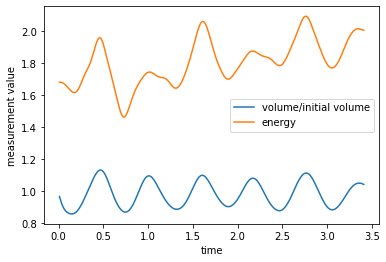

In [13]:
x_values = df['t'].values
# y_values = df['volume'].values
# y_values = df['energy'].values
plt.plot(x_values, df['volume'].values/(4*np.pi*1.**3/3), label='volume/initial volume')
plt.plot(x_values, df['energy'].values, label='energy')
plt.legend()
plt.xlabel('time')
plt.ylabel('measurement value')
plt.show()

In [14]:
# data_fn = f"avi_ns_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}.csv"

os.chdir(data_folder)
df.to_csv(data_fn, index=False)

In [15]:
print(f'results saved as {data_fn}')

results saved as newmark_asynch_fixed_lr_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.0vscale_2.0_stepsizeinit_0.0001_salience_2_atolx_1e-08.csv


In [16]:
np.array(stepsize_count_lst)
# np.savez(data_fn_counts)
np.save(data_fn_counts, np.array(stepsize_count_lst))

In [17]:
# set(stepsize_count_lst)
np.array(stepsize_count_lst[0])
np.array(stepsize_count_lst[-1])

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,   33,
       1036, 2594, 1198,  214,    2,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

# compile and save the movie using ffmpeg

In [18]:
os.chdir(nb_dir)
os.chdir(os.path.dirname(save_folder_vid))
vid_in_fn = 'out.mov'
vid_out_fn = data_fn.replace('.csv','.mov')

In [19]:
!./concat_folder_png.sh

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3.1_4 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 51.100 /

[aac @ 0x7fd5eb002a00] Qavg: 120.000
ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3.1_4 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-ind

[libx264 @ 0x7fd0ad20a200] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x7fd0ad20a200] profile High, level 3.2, 4:2:0, 8-bit
[libx264 @ 0x7fd0ad20a200] 264 - core 161 r3027 4121277 - H.264/MPEG-4 AVC codec - Copyleft 2003-2020 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=12 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=30.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mov, to 'out.mov':
  Metadata:
    encoder         : Lavf58.45.100
    Stream #0:0: Video: h264 (libx264) (avc1 / 0x31637661), yuv420p(p

In [20]:
os.chdir(nb_dir)
os.chdir(os.path.dirname(save_folder_vid))
assert(os.path.exists(vid_in_fn))
destination = shutil.copyfile(vid_in_fn, vid_out_fn) 
beep(2)

0

In [21]:
os.path.exists(vid_out_fn)

True

In [22]:
stepsize_mean

2.578401929897344e-05